In [37]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
from torch.utils.data import Dataset, DataLoader
from dataset import fMRI_Dataset, fMRI_Text_Dataset,fMRI_Augmentation_Dataset
import torch
from torch import nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

from pytorch_lightning.loggers import WandbLogger
from network import Encoder, ContrastiveModel
import torch
import torch.nn as nn
import pytorch_lightning as pl

In [ ]:
use_augmentations = True   
sub = "CSI4"
wandb.login()
wandb.init(project="BrainTuning",config={"model":"best_text_model","single_subject":True, "augmentation":use_augmentations, "sub":sub})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
subject_4_identification_accuracy,▁
subject_4_top1_acc,▁
subject_4_top5_acc,▁
train_loss_epoch,█▇▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train_loss_step,█▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_cosine_similarity,▁▃▄▅▆▆▆▇▇▇▇▇████████
val_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_mse_loss,█▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,19


In [39]:
## load the data

train_datasets=[]
val_datasets=[]
test_datasets=[]

aumentation_N = 500

for subj in tqdm.tqdm([sub]):

    subj_id = int(subj.split("CSI")[1])

    data_path =  f"/home/matteo/storage/brain_tuning/{subj}"

    train_fmri = np.load(opj(data_path, "TEXT_train_fmri_top.npy"))
    val_fmri = np.load(opj(data_path, "TEXT_val_fmri_top.npy"))
    test_fmri = np.load(opj(data_path, "TEXT_test_fmri_top.npy"))

    ##load the captions
    train_captions = np.load(opj(data_path, "train_captions.npy"),allow_pickle=True)
    val_captions = np.load(opj(data_path, "val_captions.npy"),allow_pickle=True)
    test_captions = np.load(opj(data_path, "test_captions.npy"),allow_pickle=True)

    ## load the features
    train_features = np.load(opj(data_path, "train_text_features.npy"))
    val_features = np.load(opj(data_path, "val_text_features.npy"))
    test_features = np.load(opj(data_path, "test_text_features.npy"))

    if use_augmentations:
        print("Using augmentations")
        ## load the augmentations
        train_augmentations = np.load(opj(data_path, "TEXT_augmented_brain.npy"))[:aumentation_N]
        
        # add a small noise to the augmentations
        train_augmentations = train_augmentations + np.random.normal(0,0.8,train_augmentations.shape)

        ## force the augmentations to have the same mean and std as the original fmri
        train_augmentations = train_augmentations - train_augmentations.mean(0)
        train_augmentations = train_augmentations/train_augmentations.std(0)
        train_augmentations = train_augmentations*train_fmri.std(0)
        train_augmentations = train_augmentations + train_fmri.mean(0)
        #set dtype to float32
        train_augmentations = train_augmentations.astype(np.float32)

        #load the augmented features
        train_augmented_features = np.load("/home/matteo/storage/brain_tuning/clean_augment_text_features.npy")[:aumentation_N]

        #concatenate the augmented and the original features
        train_fmri = np.concatenate([train_augmentations,train_fmri])
        train_features = np.concatenate([train_augmented_features,train_features])

        ## create the dataset
        train_dataset = fMRI_Augmentation_Dataset(train_fmri,train_features,subj_id) #no imags here, just features
    else:
        ## create the dataset
        train_dataset = fMRI_Text_Dataset(train_fmri,train_captions,train_features,subj_id)
    val_dataset = fMRI_Text_Dataset(val_fmri,val_captions,val_features,subj_id)
    test_dataset = fMRI_Text_Dataset(test_fmri,test_captions,test_features,subj_id)

    ## append the datasets
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)





  0%|          | 0/1 [00:00<?, ?it/s]

Using augmentations


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


In [40]:
## Concatenate the datasets
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)
test_dataset = torch.utils.data.ConcatDataset(test_datasets)


In [41]:
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [42]:
## optimal parameter obtained from the hyperparameter search

act_fn = nn.Identity
base_channel_size = [2048]
hidden_dims = [1024]
latent_dim = 512

loss_type = "contrastive"
lr = 1e-4
temperature = 0.1
wd = 1e-5
alpha = 0.8

In [43]:
brain_model = ContrastiveModel(num_input_channels= 10000,
                                base_channel_size=base_channel_size, 
                                hidden_dims=hidden_dims,
                                latent_dim=latent_dim,
                                act_fn=act_fn,
                                loss_type=loss_type,
                                lr = lr,
                                wd = wd,
                                alpha=alpha)

# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Create a unique checkpoint directory based on the run name or ID
run_name = wandb.run.name or wandb.run.id  # Use run name if available, otherwise use run ID
checkpoint_dir = os.path.join(data_path, "models",sub, run_name)
os.makedirs(checkpoint_dir, exist_ok=True)

# Model checkpoint configuration
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath=checkpoint_dir,filename='{sub}_TEXT_brain_model-{epoch:02d}-{val_loss:.2f}',save_top_k=3,mode='min',)


# Initialize trainer with logger

trainer = pl.Trainer(max_epochs=20, devices=[1], callbacks=[early_stop_callback,checkpoint_callback],logger=wandb_logger ) # Add the wandb logger here

trainer.fit(brain_model, train_loader, val_loader)

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/matteo/anaconda3/envs/borg/lib/python3.8/site- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call 

/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/home/matteo/anaconda3/envs/borg/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:

Epoch 0:  17%|█▋        | 1/6 [00:00<00:00, 40.15it/s]

Epoch 0: 100%|██████████| 6/6 [00:00<00:00, 53.60it/s, v_num=t641, train_loss_step=4.790, val_loss=5.430, val_mse_loss=1.850, val_cosine_similarity=0.0865, train_loss_epoch=5.980]

Metric val_loss improved. New best score: 5.434


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 54.20it/s, v_num=t641, train_loss_step=3.970, val_loss=5.170, val_mse_loss=1.780, val_cosine_similarity=0.124, train_loss_epoch=5.050] 

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 5.171


Epoch 2: 100%|██████████| 6/6 [00:00<00:00, 49.52it/s, v_num=t641, train_loss_step=3.410, val_loss=4.980, val_mse_loss=1.730, val_cosine_similarity=0.147, train_loss_epoch=4.520]

Metric val_loss improved by 0.190 >= min_delta = 0.0. New best score: 4.981


Epoch 3: 100%|██████████| 6/6 [00:00<00:00, 55.04it/s, v_num=t641, train_loss_step=3.040, val_loss=4.840, val_mse_loss=1.700, val_cosine_similarity=0.164, train_loss_epoch=4.070]

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 4.841


Epoch 4: 100%|██████████| 6/6 [00:00<00:00, 58.56it/s, v_num=t641, train_loss_step=2.650, val_loss=4.740, val_mse_loss=1.680, val_cosine_similarity=0.172, train_loss_epoch=3.680]

Metric val_loss improved by 0.101 >= min_delta = 0.0. New best score: 4.740


Epoch 5: 100%|██████████| 6/6 [00:00<00:00, 57.95it/s, v_num=t641, train_loss_step=2.340, val_loss=4.660, val_mse_loss=1.660, val_cosine_similarity=0.180, train_loss_epoch=3.330]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 4.661


Epoch 6: 100%|██████████| 6/6 [00:00<00:00, 50.77it/s, v_num=t641, train_loss_step=2.040, val_loss=4.600, val_mse_loss=1.650, val_cosine_similarity=0.184, train_loss_epoch=3.020]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 4.603


Epoch 7: 100%|██████████| 6/6 [00:00<00:00, 50.76it/s, v_num=t641, train_loss_step=1.800, val_loss=4.550, val_mse_loss=1.640, val_cosine_similarity=0.190, train_loss_epoch=2.740]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 4.548


Epoch 8: 100%|██████████| 6/6 [00:00<00:00, 56.78it/s, v_num=t641, train_loss_step=1.610, val_loss=4.490, val_mse_loss=1.630, val_cosine_similarity=0.195, train_loss_epoch=2.480]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 4.493


Epoch 9: 100%|██████████| 6/6 [00:00<00:00, 49.94it/s, v_num=t641, train_loss_step=1.460, val_loss=4.450, val_mse_loss=1.620, val_cosine_similarity=0.199, train_loss_epoch=2.260]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 4.448


Epoch 10: 100%|██████████| 6/6 [00:00<00:00, 57.51it/s, v_num=t641, train_loss_step=1.240, val_loss=4.410, val_mse_loss=1.620, val_cosine_similarity=0.203, train_loss_epoch=2.070]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 4.410


Epoch 11: 100%|██████████| 6/6 [00:00<00:00, 57.31it/s, v_num=t641, train_loss_step=1.120, val_loss=4.380, val_mse_loss=1.610, val_cosine_similarity=0.205, train_loss_epoch=1.900]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 4.383


Epoch 12: 100%|██████████| 6/6 [00:00<00:00, 56.80it/s, v_num=t641, train_loss_step=1.010, val_loss=4.360, val_mse_loss=1.610, val_cosine_similarity=0.208, train_loss_epoch=1.750]

Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 4.361


Epoch 13: 100%|██████████| 6/6 [00:00<00:00, 63.16it/s, v_num=t641, train_loss_step=0.962, val_loss=4.340, val_mse_loss=1.600, val_cosine_similarity=0.209, train_loss_epoch=1.620]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 4.345


Epoch 14: 100%|██████████| 6/6 [00:00<00:00, 63.14it/s, v_num=t641, train_loss_step=0.882, val_loss=4.330, val_mse_loss=1.600, val_cosine_similarity=0.212, train_loss_epoch=1.500]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 4.327


Epoch 15: 100%|██████████| 6/6 [00:00<00:00, 63.99it/s, v_num=t641, train_loss_step=0.750, val_loss=4.320, val_mse_loss=1.600, val_cosine_similarity=0.212, train_loss_epoch=1.410]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 4.322


Epoch 16: 100%|██████████| 6/6 [00:00<00:00, 63.12it/s, v_num=t641, train_loss_step=0.713, val_loss=4.310, val_mse_loss=1.600, val_cosine_similarity=0.213, train_loss_epoch=1.310]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 4.311


Epoch 17: 100%|██████████| 6/6 [00:00<00:00, 59.11it/s, v_num=t641, train_loss_step=0.697, val_loss=4.310, val_mse_loss=1.600, val_cosine_similarity=0.213, train_loss_epoch=1.240]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 4.309


Epoch 18: 100%|██████████| 6/6 [00:00<00:00, 63.35it/s, v_num=t641, train_loss_step=0.650, val_loss=4.300, val_mse_loss=1.590, val_cosine_similarity=0.214, train_loss_epoch=1.170]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 4.303


Epoch 19: 100%|██████████| 6/6 [00:00<00:00, 53.09it/s, v_num=t641, train_loss_step=0.580, val_loss=4.300, val_mse_loss=1.590, val_cosine_similarity=0.213, train_loss_epoch=1.110]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 4.303
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 6/6 [00:00<00:00, 11.91it/s, v_num=t641, train_loss_step=0.580, val_loss=4.300, val_mse_loss=1.590, val_cosine_similarity=0.213, train_loss_epoch=1.110]


In [44]:
# train_features.shape

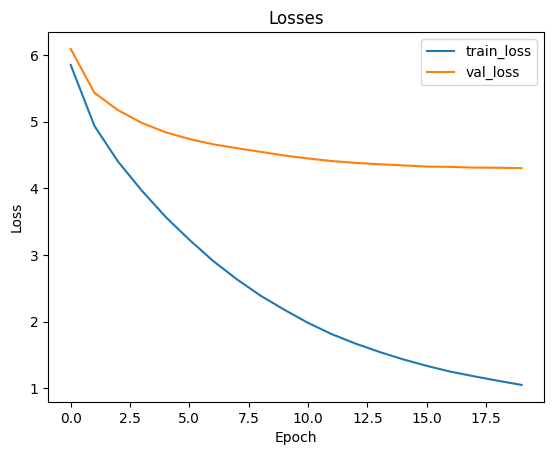

<Figure size 640x480 with 0 Axes>

In [45]:
## plot the losses
output_path = "/home/matteo/storage/brain_tuning/"

plt.plot(brain_model.train_history['train_loss'], label='train_loss')
plt.plot(brain_model.val_history['val_loss'][:-1], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.show()


if use_augmentations:
## save the plot
    plt.savefig(opj(output_path,f"single_subject_{sub}_augmented_text_losses.png"))
else:
    ## save the plot
    plt.savefig(opj(output_path,f"single_subject_{sub}_text_losses.png"))


In [46]:
from text_evaluation import *


In [47]:
results_df, similarity_matrices, results = evaluate_and_log(test_loader,brain_model)


100%|██████████| 1/1 [00:00<00:00, 27.53it/s]


Starting evaluation...
Evaluating metrics for subject 4...
Computed similarity matrix for subject 4.
Top-1 Accuracy: 0.0128, Top-5 Accuracy: 0.0557 for subject 4.
Identification accuracy for subject 4: 0.7616
Logged top-5 retrievals for subject 4.
Evaluation complete. Results loaded to wandb.


In [48]:
results_df

,Subject,Identification Accuracy (%),ID Accuracy Baseline (%),Top-1 Accuracy (%),Top1 Baseline (%),Top1 Improvement Over Baseline,Top-5 Accuracy (%),Top5 Baseline (%),Top5 Improvement Over Baseline
0,4,76.164634,50,1.284797,0.214133,6.0,5.567452,1.070664,5.2


In [49]:
# results_df.to_csv(opj(output_path,"results_text_contrastive.csv"))
## save the results

if use_augmentations:
    results_df.to_csv(opj(output_path,f"results_text_augmented_contrastive{sub}.csv"))
else:

    results_df.to_csv(opj(output_path,f"results_text_contrastive{sub}.csv"))

In [50]:
print("Done",sub,use_augmentations)

Done CSI4 True


In [51]:
def get_good_example_indices(similarity_matrix, gt_texts, num_examples=10):
    """
    Get indices of good examples where the retrieved images include the stimulus image in the top-5.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_texts (list): List of ground truth texts.
        num_examples (int): Number of good examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Identify indices where the correct image is among the top-5 retrieved
    good_examples_indices = [
        i for i in range(len(gt_texts)) if i in np.argsort(-similarity_matrix[i])[:5]
    ]
    
    # Randomly select up to `num_examples` from good examples
    if len(good_examples_indices) > num_examples:
        good_examples_indices = np.random.choice(good_examples_indices, num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each good example
    example_indices = []
    for i in good_examples_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

good_example_indices = get_good_example_indices(similarity_matrices[subj_id], results[subj_id]["gt_texts"])
good_example_indices  # [(stimulus_index, [top5_index1, top5_index2, ..., top5_index5]), ...]


[(217, [238, 217, 361, 11, 389]),
 (326, [326, 143, 263, 178, 0]),
 (270, [198, 270, 266, 250, 0]),
 (47, [339, 435, 3, 47, 20]),
 (250, [250, 415, 353, 39, 84]),
 (234, [234, 181, 66, 405, 93]),
 (120, [389, 120, 229, 302, 386]),
 (290, [397, 301, 96, 11, 290]),
 (466, [326, 466, 81, 295, 237]),
 (419, [168, 419, 78, 409, 170])]

In [52]:
def get_random_example_indices(similarity_matrix, gt_texts, num_examples=10):
    """
    Get random indices to visualize general performance of the model, with the top-5 retrieved images.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_texts (list): List of ground truth images.
        num_examples (int): Number of random examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Select random indices for visualization
    random_indices = np.random.choice(range(len(gt_texts)), num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each random example
    example_indices = []
    for i in random_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

random_example_indices = get_random_example_indices(similarity_matrices[subj_id], results[subj_id]["gt_texts"])


/tmp/ipykernel_555486/560823889.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


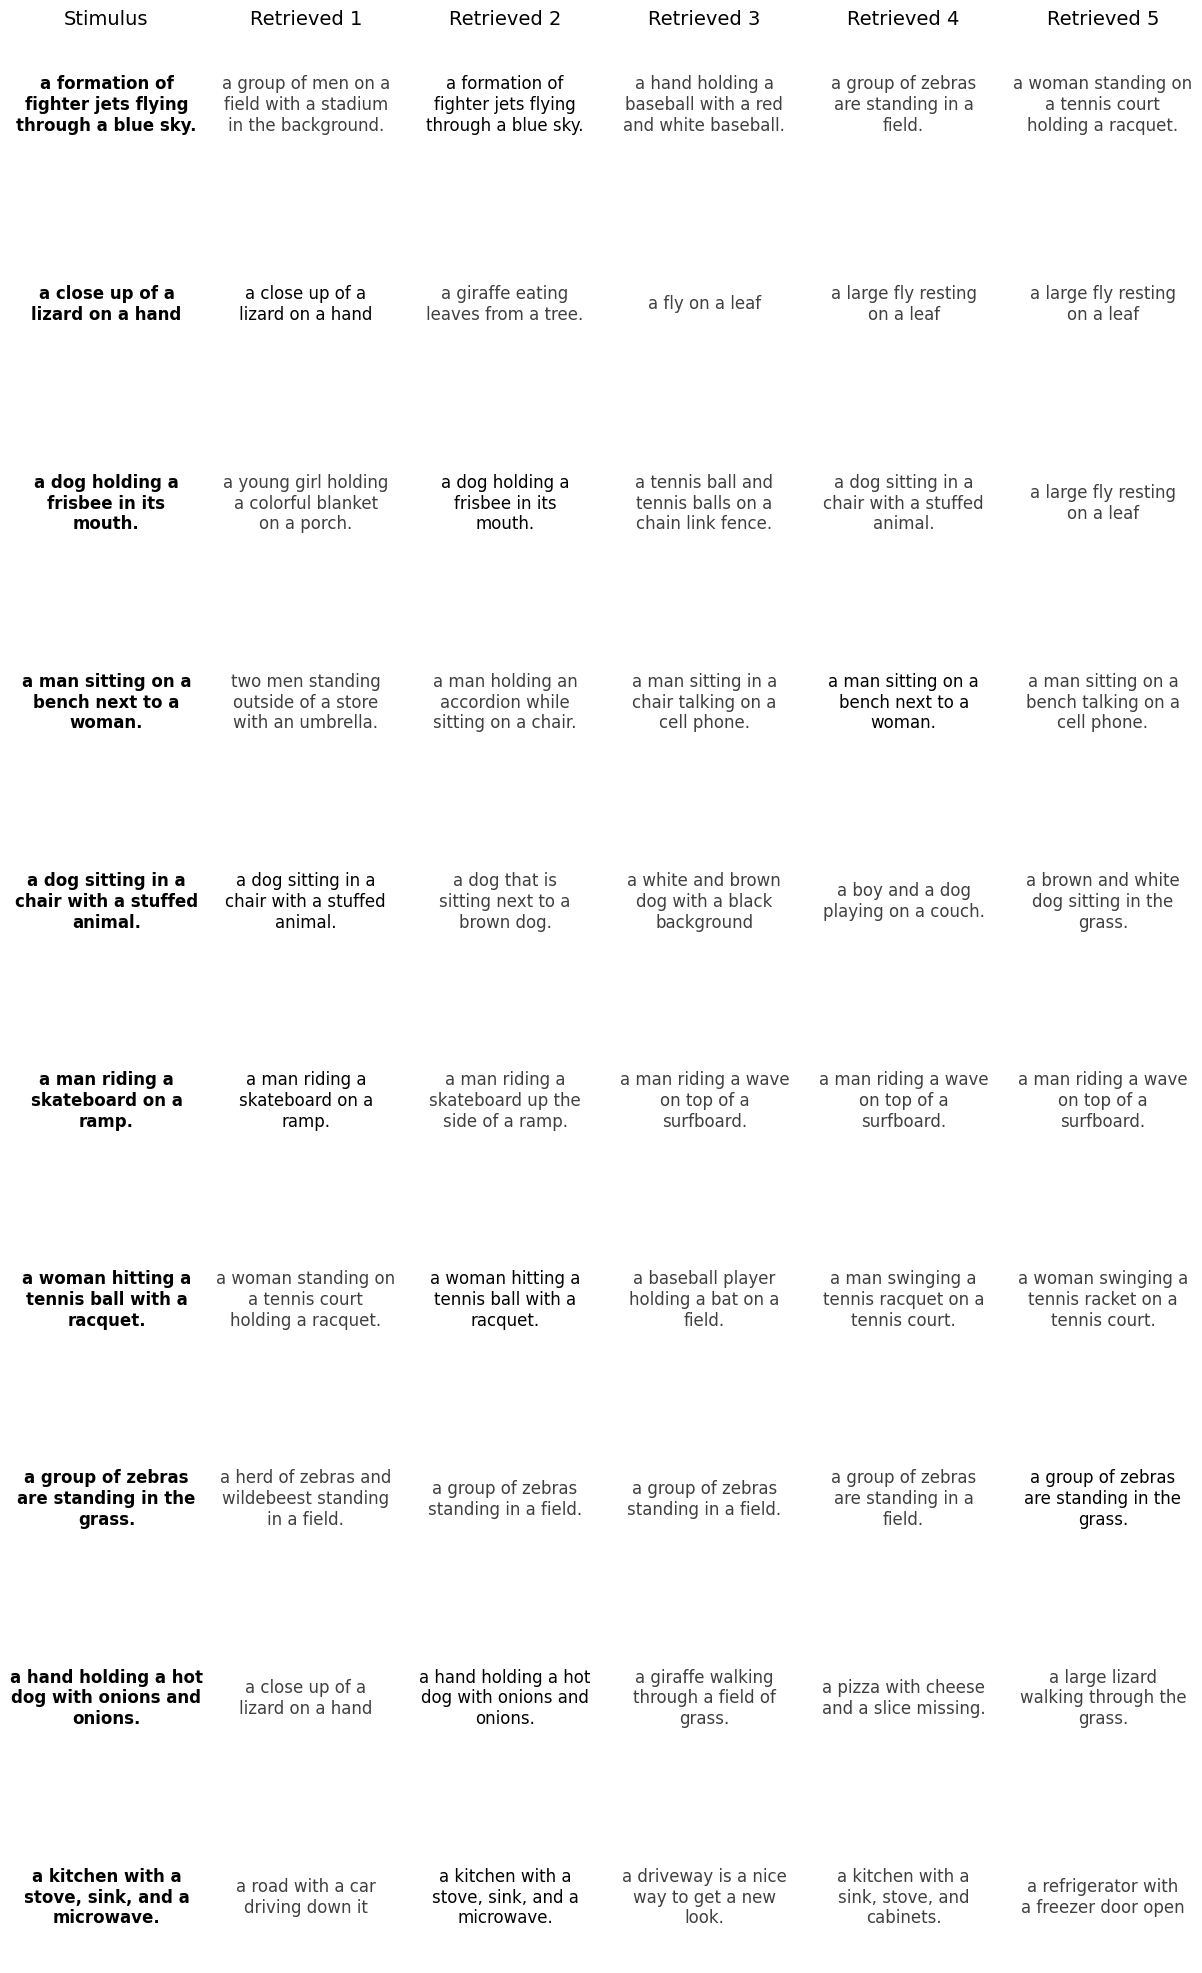

In [53]:
import matplotlib.pyplot as plt
import textwrap
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def plot_text_examples(gt_texts, example_indices, output_name="examples.png", alpha=0.75, line_width=20, similarity_matrix=None, similarity_threshold=0.6):
    """
    Plot the stimulus and top-5 retrieved captions for each good example, highlighting similar captions.

    Args:
        gt_texts (list): List of ground truth captions (text strings).
        example_indices (list): List of tuples with (stimulus_index, top5_indices) for good examples.
        output_name (str): File name to save the plot.
        alpha (float): Opacity for non-exact retrieved captions.
        line_width (int): Maximum number of characters per line for wrapping.
        similarity_matrix (np.array): Precomputed similarity matrix for captions.
        similarity_threshold (float): Threshold above which captions are considered similar and colored blue.
    """
    num_examples = len(example_indices)
    fig, axes = plt.subplots(num_examples, 6, figsize=(15, 2.5 * num_examples), facecolor="white", 
                             gridspec_kw={'wspace': 0.2, 'hspace': 0.5})
    
    for i, (stimulus_index, top5_indices) in enumerate(example_indices):
        # Plot the stimulus caption in bold
        wrapped_stimulus_text = "\n".join(textwrap.wrap(gt_texts[stimulus_index], line_width))
        axes[i, 0].text(0.5, 0.5, wrapped_stimulus_text, ha='center', va='center', wrap=True, 
                        fontsize=12, color="black", fontweight="bold")
        axes[0, 0].set_title("Stimulus", fontsize=14, pad=10)
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].set_aspect('equal')  # Make the subplot square
        axes[i,0].axis('off')

        # Plot the retrieved captions with color based on similarity
        for j, top5_idx in enumerate(top5_indices):
            wrapped_retrieved_text = "\n".join(textwrap.wrap(gt_texts[top5_idx], line_width))
            
            # Determine color based on similarity
            if similarity_matrix is not None:
                similarity_score = similarity_matrix[stimulus_index, top5_idx]
                if top5_idx == stimulus_index:
                    text_color = "green"  # Exact match
                elif similarity_score >= similarity_threshold:
                    text_color = "blue"  # Close match based on threshold
                else:
                    text_color = "black"  # Not similar enough
            else:
                text_color = "black"

            # Display text with color and opacity
            axes[i, j + 1].text(0.5, 0.5, wrapped_retrieved_text, ha='center', va='center', wrap=True,
                                fontsize=12, color=text_color, alpha=alpha if top5_idx != stimulus_index else 1)
            axes[0, j + 1].set_title(f"Retrieved {j + 1}", fontsize=14, pad=10)

            # Make each subplot square and remove ticks
            axes[i, j + 1].set_xticks([])
            axes[i, j + 1].set_yticks([])
            axes[i, j + 1].set_aspect('equal')
            axes[i,j+1].axis('off')

    plt.tight_layout(pad=0.5)
    plt.savefig(output_name)
    plt.show()

similarity_matrix = cosine_similarity(results[subj_id]["y_gt"])  
# plot_text_examples(results[subj_id]["gt_texts"], good_example_indices, output_name=opj(output_path, "good_examples.png"), similarity_matrix=similarity_matrix)


if use_augmentations:
    plot_text_examples(results[subj_id]["gt_texts"], good_example_indices,output_name=opj(output_path, f"good_text_examples_augmented_{sub}.png"))

else:
    plot_text_examples(results[subj_id]["gt_texts"], good_example_indices,output_name=opj(output_path, f"good_text_examples_{sub}.png"))


/tmp/ipykernel_555486/560823889.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


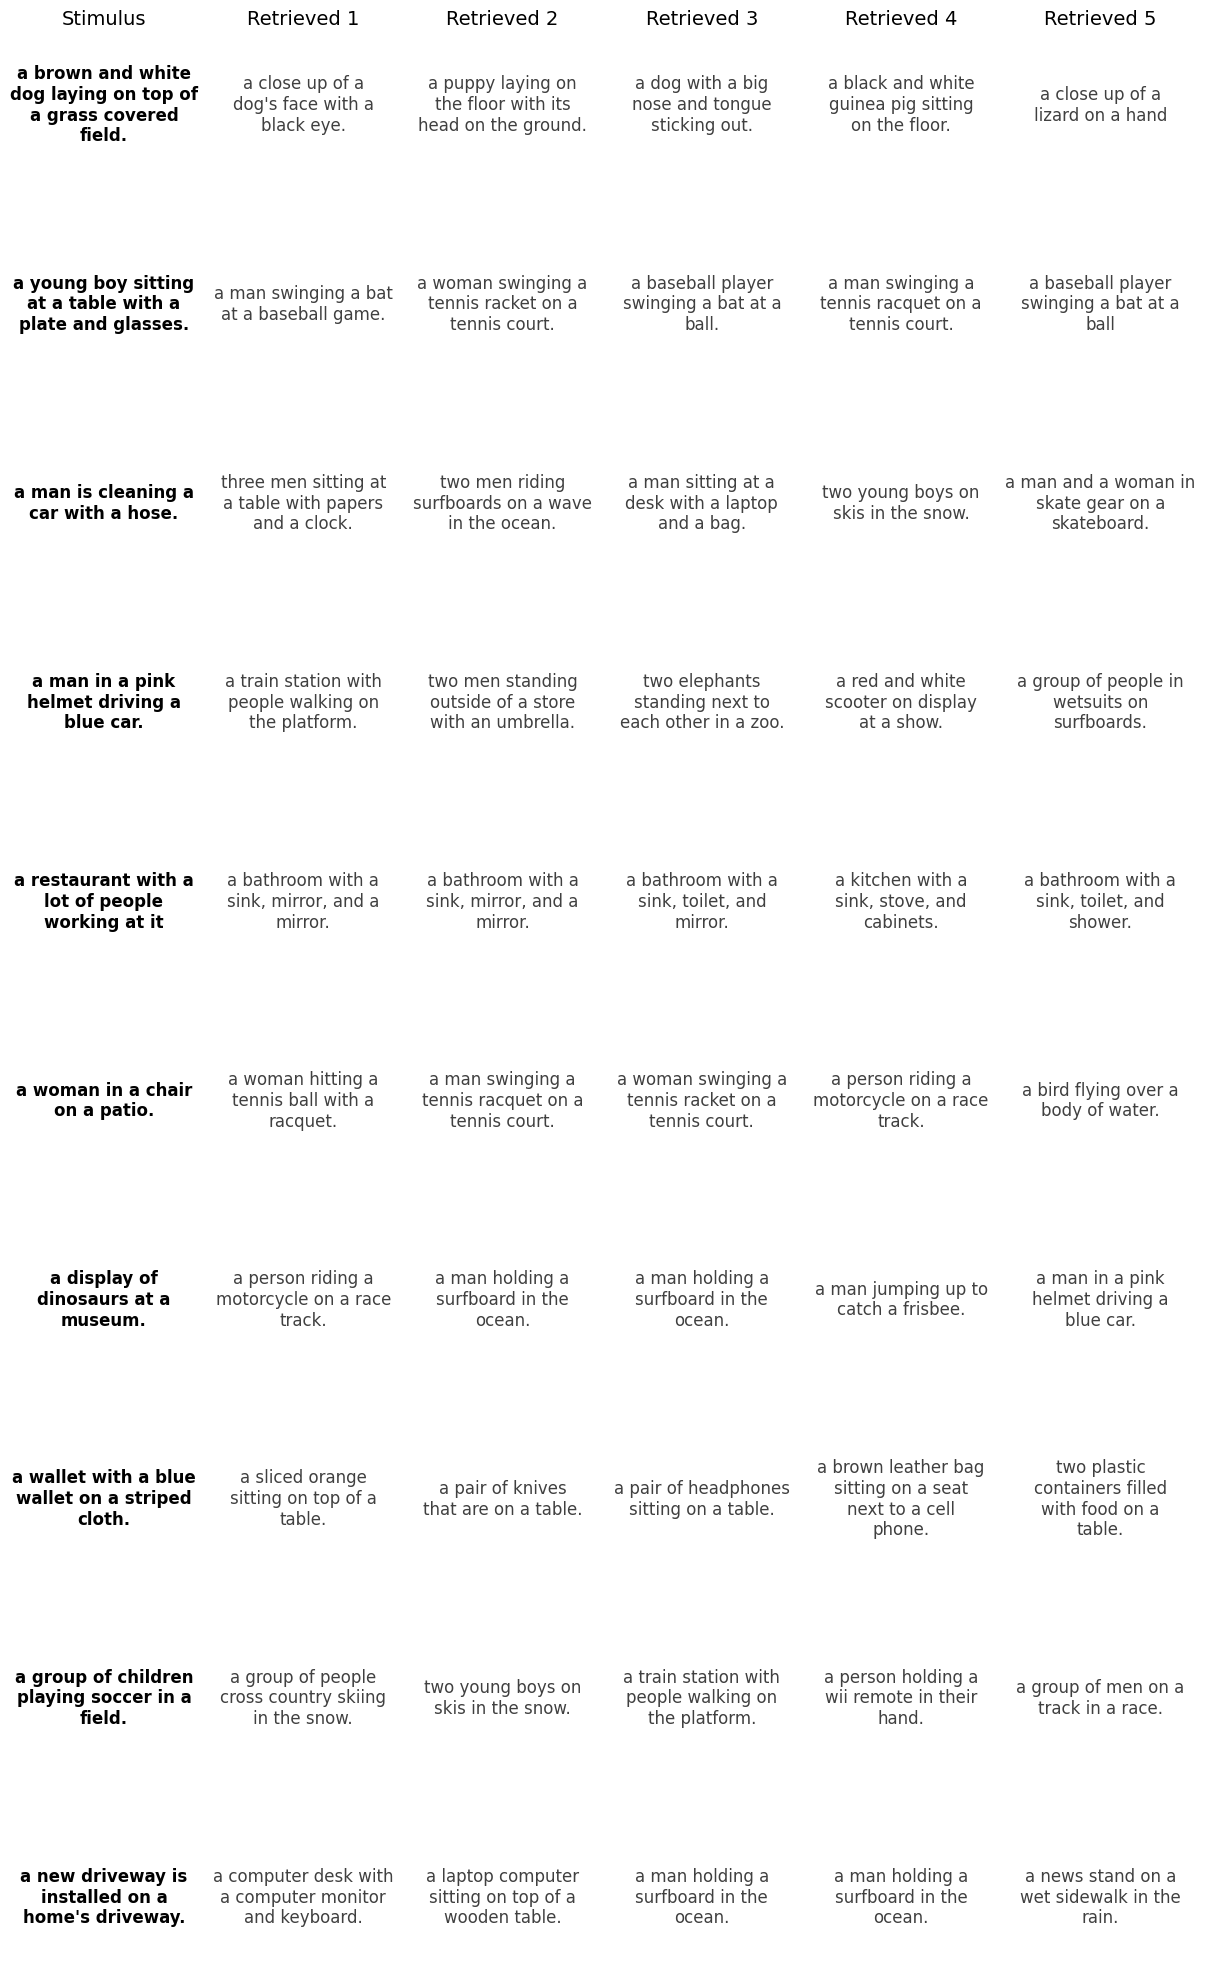

In [54]:
# plot_text_examples(results[1]["gt_texts"], random_example_indices, output_name=opj(output_path, "random_text_examples.png"))

if use_augmentations:
    plot_text_examples(results[subj_id]["gt_texts"], random_example_indices,output_name=opj(output_path, f"random_text_examples_augmented_{sub}.png"))

else:
    plot_text_examples(results[subj_id]["gt_texts"], random_example_indices,output_name=opj(output_path, f"random_text_examples_{sub}.png"))
